In [1]:
import sys
sys.path.insert(0,r'D:\local_repo\CTA_UI')
sys.path.insert(0,r'D:\local_repo\CTA_UI\utils')

In [2]:
# boundary: 一个完整的predict流程
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# Dependencies
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
from scipy.stats import norm
import matplotlib.dates as mdate
import datetime as dt
import time
from utils.rename import rename
from utils.const import client, BOUNDARY_PATH, trade_day, boundary_dict
from utils.get_contract_pair import get_exchange_on

C:\Users\Han.Hao\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
pd.options.mode.chained_assignment = None  # 默认值是'warn'

In [4]:
# Get data from start_date[MorningMarket] to end_date[EveningMarket]
def get_pairwise_data(contract_pair:list, start_date:int, end_date:int):
    start = time.time()
    select_clause = 'SELECT contract, trading_date, time, ap1, av1, bp1, bv1, volume from ctp_future_tick '
    where_clause = 'WHERE contract in ' + str(tuple(contract_pair)) + ' and trading_date >= '+ str(start_date) + ' and trading_date <= ' + str(end_date)
    query = select_clause + where_clause
    res = client.query_dataframe(query)
    print("SQL TIME: ", time.time()-start)
    if len(res) > 0:
        res = res.sort_values(by=['trading_date', 'time'])
        #res.to_csv(os.path.join(r"Z:\300_Group\HFT\Program\CTA_UI", "error_test.csv"))
        res['ms'] = res['time'].apply(lambda x: x.split(':')[3])
        # 个别tick毫秒数据会带有小数点，需要转换为整数
        res['ms'] = res['ms'].astype('float').astype('int')
        res['time'] = res.apply(lambda x: x['time'].split(':')[0] + ':' + x['time'].split(':')[1] + ':' + x['time'].split(':')[2] + ':000' if x['ms'] < 500 else x['time'].split(':')[0] + ':' + x['time'].split(':')[1] + ':' + x['time'].split(':')[2] + ':500', axis=1)

        # Inner join
        pair_data_0 = res[res['contract'] == contract_pair[0]]
        pair_data_1 = res[res['contract'] == contract_pair[1]]
        pair_data = pd.merge(pair_data_0, pair_data_1, how='inner', on=['trading_date','time'],suffixes=('_' + contract_pair[0], '_' + contract_pair[1]))
        pair_data.drop(columns=['contract_'+contract_pair[0], 'contract_'+contract_pair[1]], inplace=True)
        pair_data.sort_values(by=['trading_date', 'time'])
        pair_data = pair_data.fillna(method='ffill').replace([np.inf, -np.inf], np.nan).dropna()
    
        return pair_data
    
    else:
        return pd.DataFrame()
    

# 获取单一套利对，起止交易日之间全部早、午、夜市的tick级观测
def pair_plot_section(contract_pair:list, start_date:int, end_date:int):
    # Trading_section = [['9','11:30'], ['13:30','15:00'] ,['21:00','2:30']] or [1D, 3D, 5D, 11D, 22D]
    pair_data = get_pairwise_data(contract_pair, start_date=trade_day[trade_day.index(start_date)], end_date=trade_day[trade_day.index(end_date)])
    if len(pair_data) > 0:
        df_0 = pair_data[(pair_data['time'] > '09') & (pair_data['time'] < '11:30')]
        df_1 = pair_data[(pair_data['time'] > '13:30') & (pair_data['time'] < '15:00')]
        df_2 = pair_data[(pair_data['time'] > '21') | (pair_data['time'] < '02:30')]
        df = [df_0, df_1, df_2]
        #买近卖远 -- 买可得
        df_abr_b = [pd.concat([temp['trading_date'], (temp['ap1_' + contract_pair[0]] - temp['bp1_' + contract_pair[1]])], axis=1) for temp in df]
        #卖近买远 -- 卖可得
        df_abr_s = [(temp['bp1_' + contract_pair[0]] - temp['ap1_' + contract_pair[1]]) for temp in df]
        return df_abr_b, df_abr_s
    else:
        print("No data found in this datetime range!")
        return [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()], [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

# 返回按交易单元整理排序tick数据
def votaliry_cal_section(contract_pair:list, start_date:int, end_date:int):
    pair_data = get_pairwise_data(contract_pair, start_date=trade_day[trade_day.index(start_date)], end_date=trade_day[trade_day.index(end_date)])
    if len(pair_data) > 0:
        # 买近卖远 -- 买可得
        pair_data['buy_pair'] = pair_data['ap1_' + contract_pair[0]] - pair_data['bp1_' + contract_pair[1]]
        # 卖近买远 -- 卖可得
        pair_data['sell_pair'] = pair_data['bp1_' + contract_pair[0]] - pair_data['ap1_' + contract_pair[1]]
        # 引入自然日的概念，修正前一日晚间的夜盘日期戳，以便后期对tick数据按时序排列
        pair_data['natural_date'] = pair_data.apply(lambda x: str(trade_day[trade_day.index(x['trading_date'])-1]) if x['time']>'21' else x['trading_date'], axis=1)
        # 将数据按交易日和交易单元进行拆分排序
        df_0 = pair_data[(pair_data['time'] > '09') & (pair_data['time'] < '11:30')]
        df_0.loc[:,'date_section'] = df_0.loc[:,'natural_date'].apply(lambda x: str(x) + '_' + str(0))
        df_1 = pair_data[(pair_data['time'] > '13:30') & (pair_data['time'] < '15:00')]
        df_1.loc[:,'date_section'] = df_1.loc[:,'natural_date'].apply(lambda x: str(x) + '_' + str(1))
        df_2 = pair_data[(pair_data['time'] > '21') | (pair_data['time'] < '02:30')]
        df_2.loc[:,'date_section'] = df_2.loc[:,'trading_date'].apply(lambda x: str(trade_day[trade_day.index(x)-1]) + "_" + str(2))
        df = pd.concat([df_0, df_1, df_2])
        df['natural_date'] = pd.to_datetime(df['natural_date'], format='%Y%m%d')
        df = df.sort_values(by=['natural_date', 'date_section', 'time'])
        return df
    else:
        print("No data found in this datetime range!")
        return pd.DataFrame() 
        

# 返回一个时间窗口内每个交易单元的已实现波动率序列
def realized_votality_section(contract_pair:list, start_date:int, end_date:int, count=600):
    tick_data = votaliry_cal_section(contract_pair, start_date, end_date)
    # 这里先不考虑买卖可得和为0的情况
    tick_data['price_observe'] = (tick_data['sell_pair'] + tick_data['buy_pair']) / 2
    tick_data['mm_price_observe'] = (tick_data['price_observe'] - tick_data['price_observe'].min()) / (tick_data['price_observe'].max() - tick_data['price_observe'].min())
    tick_data['mm_price_observe'] = tick_data['mm_price_observe'] + 1
    
    # 存储return和votality的ndarray
    rtn = np.array([])
    vot = np.array([])
    realized_vot = np.array([])
    date_section_vot = []
    realized_votality = []
    for date_section, tick in tick_data.groupby('date_section'):
        open_tick = tick.iloc[:count]
        close_tick = tick.iloc[-count:]
        buy = open_tick['buy_pair'].mean()
        sell = close_tick['sell_pair'].mean()
        # 计算return
        realized_return = sell - buy
        rtn = np.append(rtn, realized_return)
        # 计算单元波动
        tick['delta_mm_price_observe'] =  tick_data['mm_price_observe'] / tick['mm_price_observe'].shift(1)
        tick = tick.dropna()
        tick.loc[:,'delta_mm_price_observe_square'] = tick.loc[:,'delta_mm_price_observe'] ** 2
        votality = tick['delta_mm_price_observe_square'].sum()
        vot = np.append(vot, votality)
        date_section_vot.append((date_section, votality))
    # 最终波动率等于收益序列的方差/波动序列的均值
    # 按每个交易单元输出对应的值:
    for vot_section in date_section_vot:
        vot_date_section = vot_section[0]
        vot_value = vot_section[1]
        realized_votality_value = rtn.var() / vot.mean() * vot_value
        realized_votality.append((vot_date_section, realized_votality_value))
    return realized_votality 

# 检查tick数据

In [76]:
sc_data = votaliry_cal_section(['sc2405','sc2406'], 20240223,20240223)

SQL TIME:  0.7279965877532959


In [4]:
import seaborn as sns
%matplotlib inline
%matplotlib notebook

In [78]:
# buy_pair 买可得-对应买近期的卖1和卖远期的买1
# sell_pair 卖可得-对应卖近期的买1和买远期的卖1
sc_data['buy_pair_volume'] = sc_data.apply(lambda x: min(x['av1_sc2405'], x['bp1_sc2406']) * 1000, axis=1)
sc_data['sell_pair_volume'] = sc_data.apply(lambda x: min(x['bp1_sc2405'], x['av1_sc2406']) * 1000, axis=1)

In [79]:
sc_data_motion = sc_data[['time', 'buy_pair_volume', 'sell_pair_volume', 'buy_pair', 'sell_pair']]

In [80]:
sc_data_motion['buy_pair'] = sc_data_motion['buy_pair'] * 100
sc_data_motion['sell_pair'] = sc_data_motion['sell_pair'] * 100

In [81]:
sc_data_motion['buy_pair_volume'] = sc_data_motion['buy_pair_volume'].apply(lambda x: "[" + str(x) + "]")
sc_data_motion['sell_pair_volume'] = sc_data_motion['sell_pair_volume'].apply(lambda x: "[" + str(x) + "]")
sc_data_motion['buy_pair'] = sc_data_motion['buy_pair'].apply(lambda x: "[" + str(int(x)) + "]")
sc_data_motion['sell_pair'] = sc_data_motion['sell_pair'].apply(lambda x: "[" + str(int(x)) + "]")

In [82]:
sc_data_motion

,time,buy_pair_volume,sell_pair_volume,buy_pair,sell_pair
24221,21:00:00:500,[2000],[1000],[429],[289]
24222,21:00:01:000,[1000],[1000],[400],[330]
24223,21:00:01:500,[1000],[1000],[420],[329]
24224,21:00:02:000,[5000],[8000],[420],[340]
24225,21:00:02:500,[2000],[1000],[420],[350]
...,...,...,...,...,...
24216,14:59:56:500,[4000],[2000],[559],[470]
24217,14:59:57:000,[4000],[2000],[559],[470]
24218,14:59:57:500,[2000],[2000],[559],[470]
24219,14:59:58:000,[3000],[2000],[559],[470]


In [83]:
output = sc_data_motion[['time','sell_pair', 'sell_pair_volume','buy_pair','buy_pair_volume']]

In [84]:
output['seq'] = pd.Series([i for i in range(len(output))])

In [85]:
output = output[['seq', 'time','sell_pair', 'sell_pair_volume','buy_pair','buy_pair_volume']]

In [86]:
output.to_csv("sc_check.csv", index=False)

In [5]:
motion_df = pd.read_csv("sc_check_motion.csv")

In [7]:
motion_df

,SeqNo,Datetime,Motion,Ask1_p,Ask1_v,Bid1_p,Bid1_v
0,24222,21:00:01:000,1000,4.00,1000,3.30,1000
1,24223,21:00:01:500,0,4.20,1000,3.29,1000
2,24224,21:00:02:000,3000,4.20,5000,3.40,8000
3,24225,21:00:02:500,-4000,4.20,2000,3.50,1000
4,24226,21:00:03:000,3000,4.29,2000,3.70,4000
...,...,...,...,...,...,...,...
42376,24216,14:59:56:500,1000,5.59,4000,4.70,2000
42377,24217,14:59:57:000,0,5.59,4000,4.70,2000
42378,24218,14:59:57:500,2000,5.59,2000,4.70,2000
42379,24219,14:59:58:000,-1000,5.59,3000,4.70,2000


In [23]:
motion_df

,SeqNo,Datetime,Motion,Ask1_p,Ask1_v,Bid1_p,Bid1_v
0,24222,21:00:01:000,1000,4.00,1000,3.30,1000
1,24223,21:00:01:500,0,4.20,1000,3.29,1000
2,24224,21:00:02:000,3000,4.20,5000,3.40,8000
3,24225,21:00:02:500,-4000,4.20,2000,3.50,1000
4,24226,21:00:03:000,3000,4.29,2000,3.70,4000
...,...,...,...,...,...,...,...
42376,24216,14:59:56:500,1000,5.59,4000,4.70,2000
42377,24217,14:59:57:000,0,5.59,4000,4.70,2000
42378,24218,14:59:57:500,2000,5.59,2000,4.70,2000
42379,24219,14:59:58:000,-1000,5.59,3000,4.70,2000


In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# 提取高于90%分位数和低于10%分位数的时间点
motion_up_quantile = motion_df['Motion'].quantile(0.99)
motion_down_quantile = motion_df['Motion'].quantile(0.01)

datetime_up = motion_df[motion_df['Motion'] > motion_up_quantile]['Datetime']
datetime_down = motion_df[motion_df['Motion'] < motion_down_quantile]['Datetime']

# 转换时间格式
datetime_up = pd.to_datetime(datetime_up, format='%H:%M:%S:%f').dt.time
datetime_down = pd.to_datetime(datetime_down, format='%H:%M:%S:%f').dt.time


<IPython.core.display.Javascript object>


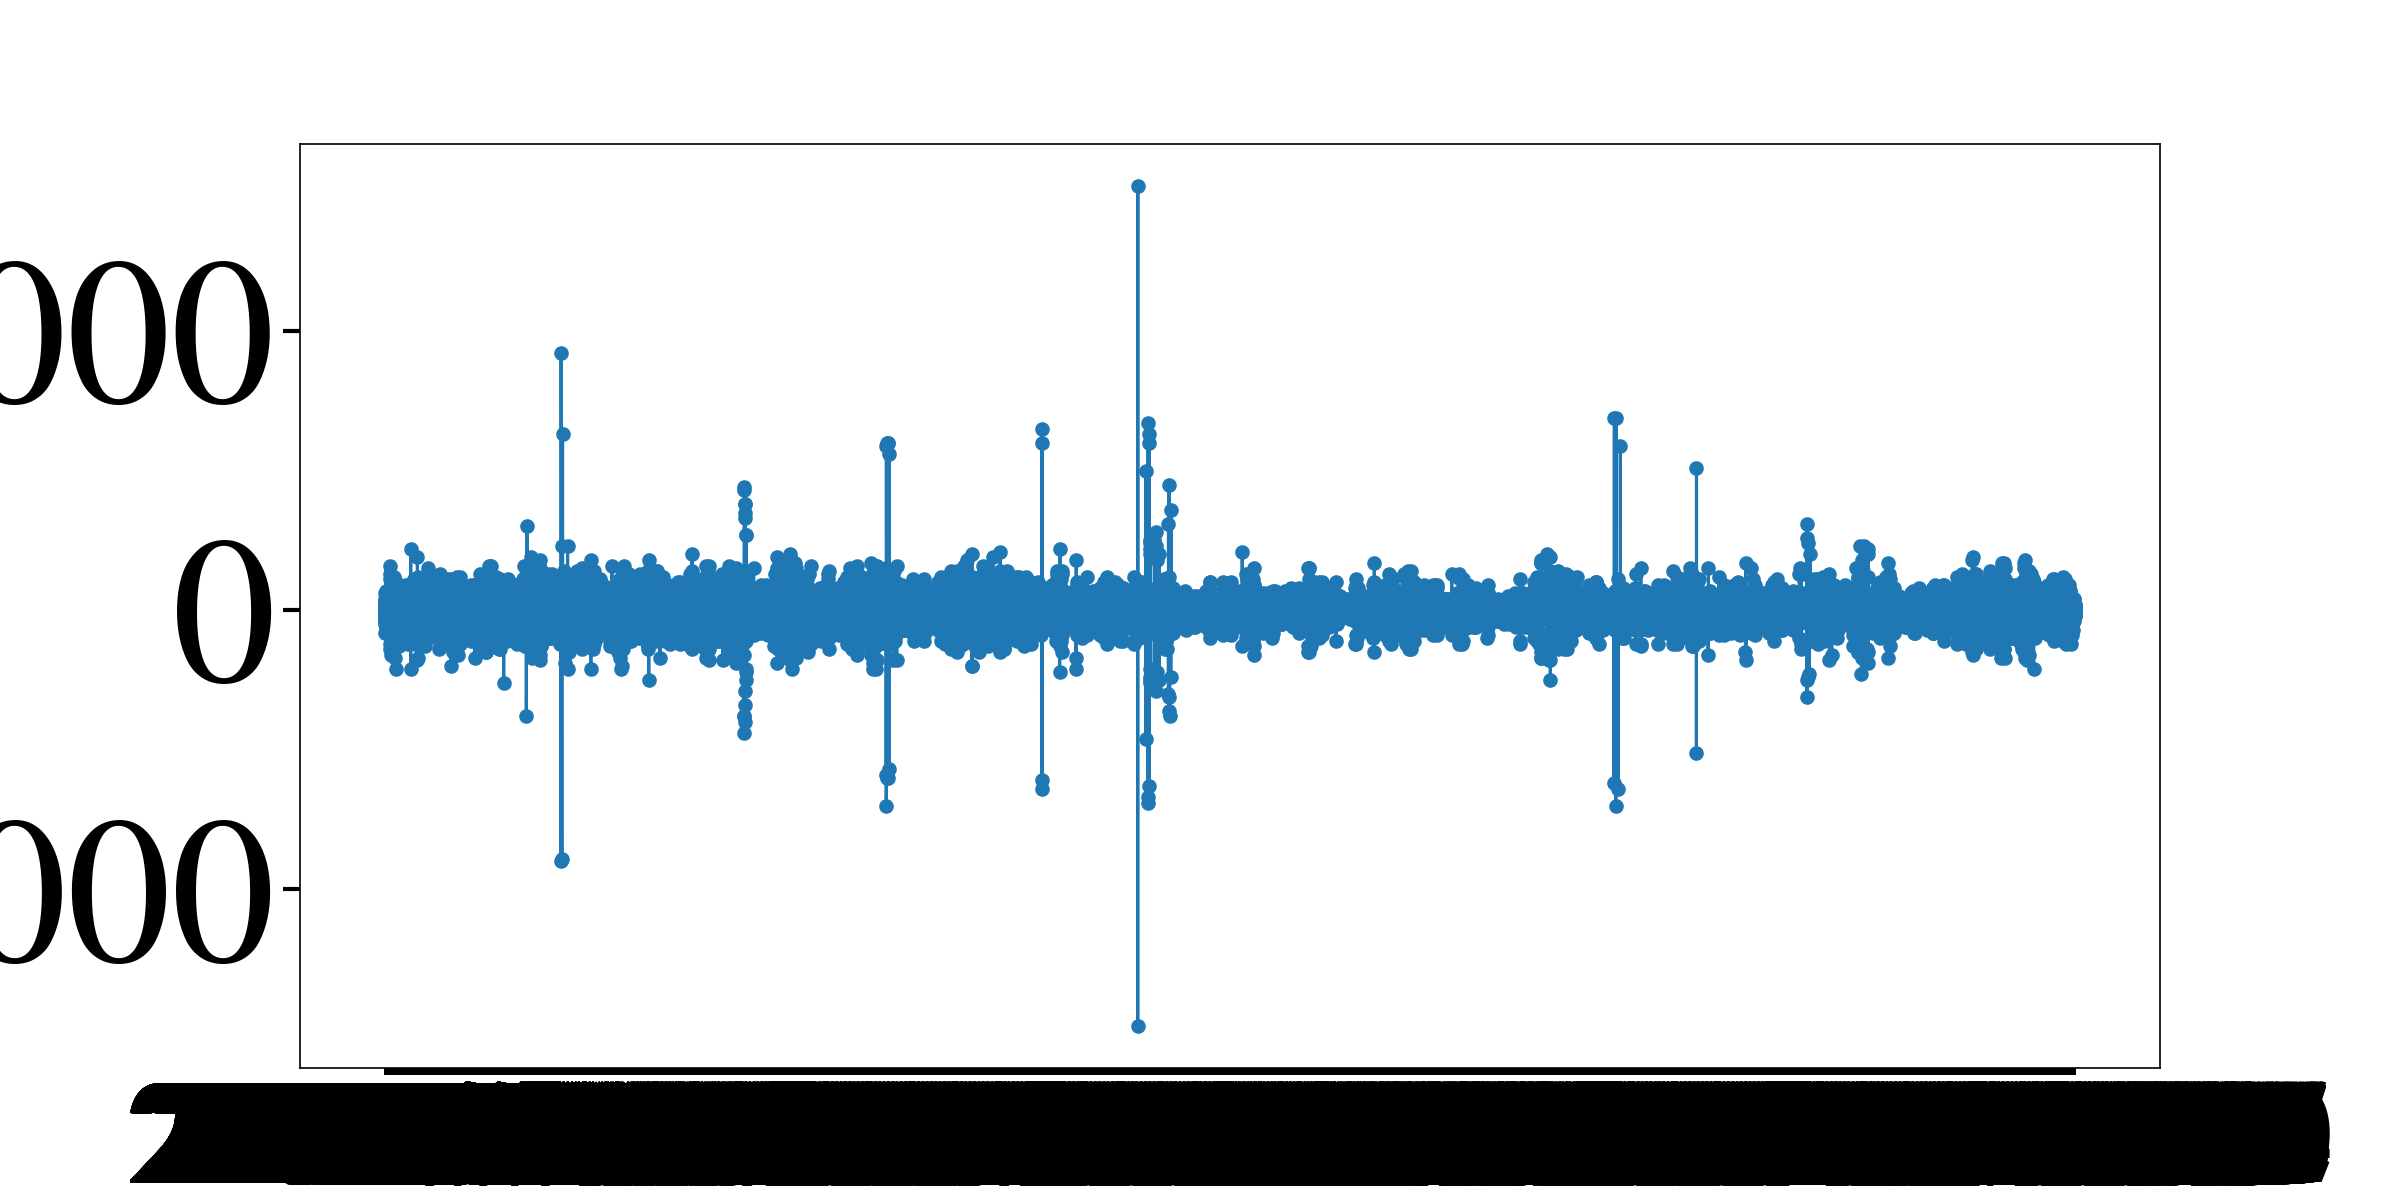

ConversionError: Failed to convert value(s) to axis units: 149             21:01:16
154      21:01:18.500000
157             21:01:20
167             21:01:25
259      21:02:13.500000
              ...       
41527    14:25:51.500000
41936    14:43:36.500000
41948           14:43:56
42124           14:51:35
42163           14:52:37
Name: Datetime, Length: 407, dtype: object

In [34]:

# 设置图形尺寸和字体大小
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 12})

# 绘制折线图
plt.plot(datetime, motion, marker='o', linestyle='-')
plt.scatter(datetime_up, motion_df[motion_df['Motion'] > motion_up_quantile]['Motion'], color='r', label='Above 90th percentile')
plt.scatter(datetime_down, motion_df[motion_df['Motion'] < motion_down_quantile]['Motion'], color='g', label='Below 10th percentile')
plt.title('Motion Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Motion', fontsize=14)
plt.legend()

# 设置横轴仅显示特定时间点
plt.xticks(ticks=pd.concat([datetime_up, datetime_down]), rotation=45)
plt.tight_layout()

plt.savefig("motion.png")
plt.show()


In [108]:
# 返回时间窗口放波和缩波的交易单元
def votality_signal(realized_votality_value:list, quantile=1.3):
    vot_df = pd.DataFrame(realized_votality_value)
    vot_df = vot_df.rename(columns={vot_df.columns[0]:"date_section", vot_df.columns[1]:"vot"})
    vot_df["vot"] = np.cbrt(vot_df["vot"])
    vot_up_boundary = vot_df['vot'].mean() + quantile * vot_df['vot'].std()
    vot_down_boundary = vot_df['vot'].mean() - quantile * vot_df['vot'].std()
    expand = vot_df[vot_df['vot'] >= vot_up_boundary]["date_section"].tolist()
    shrink = vot_df[vot_df['vot'] <= vot_down_boundary]["date_section"].tolist()
    return expand, shrink

In [133]:
def votality_window_cal(contract_pair:list,start_date:int, end_date:int, window=20):
    vot_seq = dict()
    date_range = trade_day[trade_day.index(start_date):trade_day.index(end_date)+1]
    for day in date_range:
        pre_day = trade_day[trade_day.index(day)-window]
        realized_vot = realized_votality_section(contract_pair, pre_day, day)
        vot_seq[day] = realized_vot
        expand, shrink = votality_signal(realized_vot)
        # 检查当日是否有放波/缩波现象
        print("+++++++++++++++")
        print("日期：",day)
        if len(expand) > 0:
            expand_day = int(max(expand).split("_")[0])
            if expand_day == day or expand_day == trade_day[trade_day.index(day)-1]:
                expand_signal_section = []
                for date_section in expand:
                    if (int(date_section.split("_")[0]) == day) or (int(date_section.split("_")[0]) == trade_day[trade_day.index(day)-1]):
                        expand_signal_section.append(date_section)
                print("**放波信号**:{}".format(expand_signal_section))
                
        if len(shrink) > 0:
            shrink_day = int(max(shrink).split("_")[0])
            if shrink_day == day or shrink_day == trade_day[trade_day.index(day)-1]:
                shrink_signal_section = []
                for date_section in shrink:
                    if (int(date_section.split("_")[0]) == day) or (int(date_section.split("_")[0]) == trade_day[trade_day.index(day)-1]):
                        shrink_signal_section.append(date_section)
                print("**缩波信号**:{}".format(shrink_signal_section))     
                
        if len(expand) == 0 and len(shrink) == 0:
            print("日期:{}时间窗口内无波动性")
        print("时间窗口内放波单元：", expand)
        print("时间窗口内缩波单元：", shrink)
        print("+++++++++++++++")
    return vot_seq

In [110]:
vot_seq = votality_window_cal(['ni2311','ni2312'], 20230913, 20231106)

SQL TIME:  22.05799961090088
+++++++++++++++
日期： 20230913
时间窗口内放波单元： ['20230815_2', '20230816_2', '20230817_2', '20230818_0', '20230818_1', '20230821_2', '20230901_2']
时间窗口内缩波单元： ['20230823_1', '20230824_1', '20230825_1']
+++++++++++++++
SQL TIME:  21.452776432037354
+++++++++++++++
日期： 20230914
时间窗口内放波单元： ['20230816_2', '20230817_2', '20230818_0', '20230818_1', '20230821_2', '20230901_2']
时间窗口内缩波单元： ['20230823_1', '20230824_1', '20230825_1']
+++++++++++++++
SQL TIME:  22.12600064277649
+++++++++++++++
日期： 20230915
时间窗口内放波单元： ['20230817_2', '20230818_0', '20230818_1', '20230821_2', '20230901_2']
时间窗口内缩波单元： ['20230823_1', '20230824_1', '20230825_1']
+++++++++++++++
SQL TIME:  22.301000595092773
+++++++++++++++
日期： 20230918
时间窗口内放波单元： ['20230818_2', '20230821_2', '20230831_2', '20230901_2', '20230904_2', '20230905_2', '20230906_2', '20230907_2']
时间窗口内缩波单元： ['20230823_1', '20230824_1', '20230825_1']
+++++++++++++++
SQL TIME:  22.21299386024475
+++++++++++++++
日期： 20230919
时间窗口内放波单元： ['202

In [122]:
vot_seq = votality_window_cal(['sc2402','sc2403'], 20230913, 20231106)

SQL TIME:  26.573602437973022
+++++++++++++++
日期： 20231122
时间窗口内放波单元： ['20231030_2', '20231031_2', '20231101_2', '20231102_2', '20231103_2', '20231106_2', '20231107_2', '20231108_2', '20231109_2', '20231110_2', '20231113_2', '20231114_2', '20231115_2', '20231116_2', '20231117_2']
时间窗口内缩波单元： ['20231025_1']
+++++++++++++++
SQL TIME:  26.487024784088135
+++++++++++++++
日期： 20231123
**放波信号**:20231122_2
时间窗口内放波单元： ['20231030_2', '20231031_2', '20231101_2', '20231102_2', '20231103_2', '20231106_2', '20231107_2', '20231108_2', '20231109_2', '20231110_2', '20231113_2', '20231114_2', '20231115_2', '20231116_2', '20231117_2', '20231122_2']
时间窗口内缩波单元： []
+++++++++++++++
SQL TIME:  26.827791452407837
+++++++++++++++
日期： 20231124
时间窗口内放波单元： ['20231030_2', '20231031_2', '20231101_2', '20231102_2', '20231103_2', '20231106_2', '20231107_2', '20231108_2', '20231109_2', '20231110_2', '20231113_2', '20231114_2', '20231115_2', '20231116_2', '20231117_2', '20231122_2']
时间窗口内缩波单元： []
+++++++++++++++
SQL TIM

SQL TIME:  23.45000433921814
+++++++++++++++
日期： 20240102
**放波信号**:20231229_0
时间窗口内放波单元： ['20231228_0', '20231228_1', '20231228_2', '20231229_0']
时间窗口内缩波单元： ['20240102_1']
+++++++++++++++
SQL TIME:  23.17900037765503
+++++++++++++++
日期： 20240103
时间窗口内放波单元： ['20231228_0', '20231228_1', '20231228_2', '20231229_0']
时间窗口内缩波单元： ['20240102_1', '20240103_1']
+++++++++++++++
SQL TIME:  22.561002254486084
+++++++++++++++
日期： 20240104
时间窗口内放波单元： ['20231228_0', '20231228_1', '20231228_2', '20231229_0']
时间窗口内缩波单元： ['20240102_1', '20240103_1', '20240104_1']
+++++++++++++++
SQL TIME:  24.50300145149231
+++++++++++++++
日期： 20240105
时间窗口内放波单元： ['20231228_0', '20231228_1', '20231228_2', '20231229_0']
时间窗口内缩波单元： ['20240102_1', '20240103_1', '20240105_1']
+++++++++++++++
SQL TIME:  22.994999647140503
+++++++++++++++
日期： 20240108
**缩波信号**:20240105_1
时间窗口内放波单元： ['20231228_0', '20231228_1', '20231228_2', '20231229_0']
时间窗口内缩波单元： ['20240102_1', '20240103_1', '20240105_1']
+++++++++++++++
SQL TIME:  22.572988

In [134]:
vot_seq = votality_window_cal(['ni2310','ni2311'], 20230824, 20231016)

SQL TIME:  28.00495743751526
+++++++++++++++
日期： 20230824
时间窗口内放波单元： ['20230808_0', '20230808_1', '20230815_0', '20230818_0', '20230818_1']
时间窗口内缩波单元： []
+++++++++++++++
SQL TIME:  34.36699962615967
+++++++++++++++
日期： 20230825
**缩波信号**:['20230825_1']
时间窗口内放波单元： ['20230808_0', '20230808_1', '20230815_0', '20230818_0', '20230818_1']
时间窗口内缩波单元： ['20230825_1']
+++++++++++++++
SQL TIME:  36.54901885986328
+++++++++++++++
日期： 20230828
**缩波信号**:['20230825_1']
时间窗口内放波单元： ['20230808_0', '20230808_1', '20230815_0', '20230818_0', '20230818_1']
时间窗口内缩波单元： ['20230825_1']
+++++++++++++++
SQL TIME:  25.735002279281616
+++++++++++++++
日期： 20230829
时间窗口内放波单元： ['20230808_0', '20230808_1', '20230815_0', '20230818_0', '20230818_1']
时间窗口内缩波单元： []
+++++++++++++++
SQL TIME:  23.237999439239502
+++++++++++++++
日期： 20230830
时间窗口内放波单元： ['20230808_0', '20230808_1', '20230815_0', '20230818_0', '20230818_1']
时间窗口内缩波单元： []
+++++++++++++++
SQL TIME:  23.49567174911499
+++++++++++++++
日期： 20230831
时间窗口内放波单元： ['20230

In [135]:
vot_lst = []
for key, value in vot_seq.items():
    for vot in value:
        vot_lst.append((key, vot[0], vot[1]))
vot_df = pd.DataFrame(vot_lst)

In [136]:
vot_df

,0,1,2
0,20230824,20230726_2,9852.570173
1,20230824,20230727_0,5833.245092
2,20230824,20230727_1,3875.869229
3,20230824,20230727_2,9116.891647
4,20230824,20230728_0,5425.163630
...,...,...,...
2035,20231016,20231013_0,37143.418553
2036,20231016,20231013_1,49176.609216
2037,20231016,20231013_2,185301.231967
2038,20231016,20231016_0,75887.048296


In [137]:
vot_df = vot_df.rename(columns={0:"trade_day",1:"date_section", 2:"vot"})

In [138]:
vot_df.to_csv(r"D:\local_repo\CTA_UI\utils\ni2310-2311.csv")

In [73]:
vot_df = pd.read_csv(r"D:\local_repo\CTA_UI\utils\vot_seq.csv")

In [77]:
vot_df['']

,Unnamed: 0,0,date_section,vot
0,0,20231016,20230922_2,6357.160950
1,1,20231016,20230925_0,4034.608458
2,2,20231016,20230925_1,2681.243545
3,3,20231016,20230925_2,6238.755456
4,4,20231016,20230926_0,3853.063962
...,...,...,...,...
485,485,20231106,20231103_0,20182.078747
486,486,20231106,20231103_1,14289.457411
487,487,20231106,20231103_2,30242.967258
488,488,20231106,20231106_0,21709.779174


In [8]:
import scipy.stats as stats
print("Skewness:", stats.skew(vot_df['2']))
print("Kurtosis:", stats.kurtosis(vot_df['2']))

Skewness: 2.197423817906677
Kurtosis: 6.726596610411809


In [9]:
vot_norm = np.cbrt(vot_df['2'])

In [10]:
print("Skewness:", stats.skew(vot_norm))
print("Kurtosis:", stats.kurtosis(vot_norm))

Skewness: 0.4351672991978527
Kurtosis: 0.29613317825836116


<Axes: >

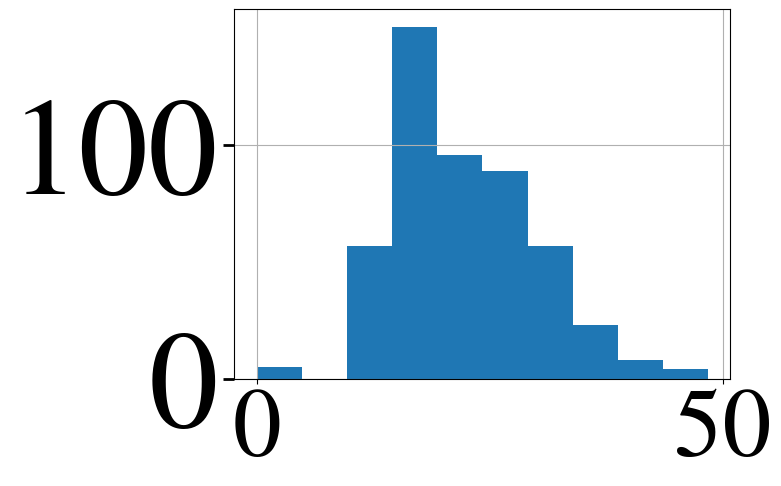

In [11]:
vot_norm.hist()

<Axes: >

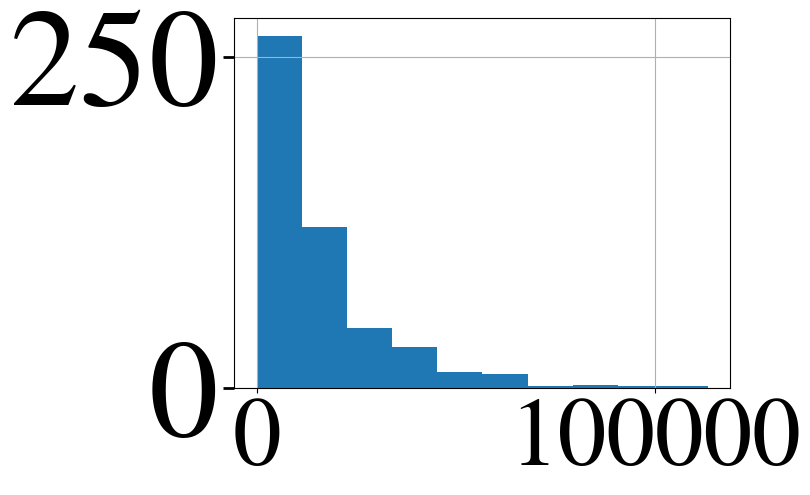

In [14]:
vot_df['2'].hist()

In [18]:
vot_df.loc[:,'2'] = np.cbrt(vot_df.loc[:,'2'])

In [24]:
vot_df = vot_df.sort_values(by="2", ascending=False)

In [30]:
set(vot_df.iloc[:40]['1'].tolist())

{'20231017_2',
 '20231018_0',
 '20231018_1',
 '20231018_2',
 '20231019_0',
 '20231019_1',
 '20231019_2',
 '20231023_2',
 '20231024_0',
 '20231024_2',
 '20231025_2',
 '20231026_2',
 '20231027_2'}

<Axes: >

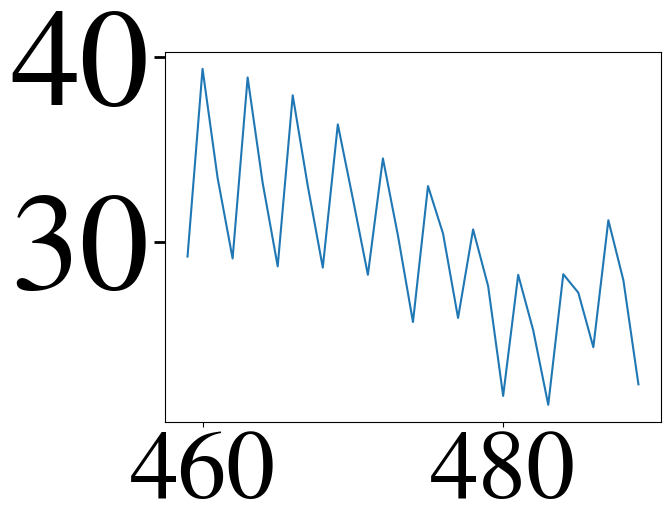

In [55]:
vot_df[(vot_df['0'] == 20231106)].sort_values(by="1")['2'].plot()

In [61]:
for date,data in vot_df.groupby('0'):
    print("参考日：",date)
    vot_up_boundary = data['2'].mean() + 0.53*data['2'].std()
    vot_down_boundary = data['2'].mean() - 0.53*data['2'].std()
    fangbo = data[data['2'] >= vot_up_boundary]
    suobo = data[data['2'] <= vot_down_boundary]
    print("放波单元：", fangbo['1'].tolist())
    print("缩波单元：", suobo['1'].tolist())

参考日： 20231016
放波单元： ['20231013_2', '20231010_2', '20230927_2', '20231012_2', '20230922_2', '20231011_2', '20230925_2', '20230926_2', '20231009_2']
缩波单元： ['20230928_2']
参考日： 20231017
放波单元： ['20231016_2', '20231013_2', '20231010_2', '20230927_2', '20231012_2', '20231011_2', '20230925_2', '20230926_2', '20231009_2']
缩波单元： ['20230928_2']
参考日： 20231018
放波单元： ['20231018_1', '20231018_0', '20231016_2', '20231013_2', '20231010_2', '20230927_2', '20231012_2', '20231017_2', '20231011_2', '20230926_2', '20231009_2']
缩波单元： ['20231016_1', '20231017_1', '20231013_1', '20231011_1', '20230928_1', '20230928_2']
参考日： 20231019
放波单元： ['20231019_0', '20231018_1', '20231019_1', '20231018_0', '20231018_2', '20231016_2']
缩波单元： ['20231012_1', '20231009_1', '20231010_1', '20231016_1', '20231017_1', '20231013_1', '20231011_1', '20230928_1', '20230928_2']
参考日： 20231020
放波单元： ['20231019_0', '20231018_1', '20231019_1', '20231018_0', '20231018_2', '20231019_2', '20231016_2']
缩波单元： ['20231020_1', '20231012_1', '20231